## Generating Handwrittn Digits

In [150]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

In [151]:
from pathlib import Path
from os import cpu_count
from tqdm import tqdm
from IPython.display import Image
from timeit import default_timer as timer
from shutil import rmtree

In [152]:
!pip install torchinfo --quiet

In [153]:
from torchinfo import summary

## Setting Default Device

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Creating the Transformations

In [155]:
train_tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [156]:
# Creating the Denormalize Function
def denorm(x):
    return (x + 1) / 2

## Loading the Dataset

In [157]:
dataset = datasets.MNIST(root="/content", download=True, train=True, transform=train_tr)

print(len(dataset))

60000


## Creating the Data Loader

In [158]:
BATCH_SIZE = 128

train_dl = DataLoader(dataset=dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=cpu_count(),
                      pin_memory=True)

print(len(train_dl))

469


## Creating the Discriminator Model

In [159]:
class DiscriminatorN(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2, hidden_size_3):
        super().__init__()

        self.linear_layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=image_size, out_features=hidden_size_1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.linear_layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.linear_layer_3 = nn.Sequential(
            nn.Linear(in_features=hidden_size_2, out_features=hidden_size_3),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.linear_layer_4 = nn.Sequential(
            nn.Linear(in_features=hidden_size_3, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_layer_4(self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x))))

## Initializing the Discriminator

In [160]:
discriminator = DiscriminatorN(28*28, 128, 256, 512).to(device)

summary(discriminator,
        input_size=(BATCH_SIZE, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
DiscriminatorN (DiscriminatorN)          [128, 1, 28, 28]     [128, 1]             --                   True
├─Sequential (linear_layer_1)            [128, 1, 28, 28]     [128, 128]           --                   True
│    └─Flatten (0)                       [128, 1, 28, 28]     [128, 784]           --                   --
│    └─Linear (1)                        [128, 784]           [128, 128]           100,480              True
│    └─LeakyReLU (2)                     [128, 128]           [128, 128]           --                   --
├─Sequential (linear_layer_2)            [128, 128]           [128, 256]           --                   True
│    └─Linear (0)                        [128, 128]           [128, 256]           33,024               True
│    └─LeakyReLU (1)                     [128, 256]           [128, 256]           --                   --
├─Sequential (linear

## Creating the Generator Model

In [161]:
class GeneratorN(nn.Module):
    def __init__(self, latent_size, hidden_size_1, hidden_size_2, hidden_size_3, image_size):
        super().__init__()

        self.linear_layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=latent_size, out_features=hidden_size_1),
            nn.ReLU(inplace=True)
        )

        self.linear_layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2),
            nn.ReLU(inplace=True)
        )

        self.linear_layer_3 = nn.Sequential(
            nn.Linear(in_features=hidden_size_2, out_features=hidden_size_3),
            nn.ReLU(inplace=True)
        )

        self.linear_layer_4 = nn.Sequential(
            nn.Linear(in_features=hidden_size_3, out_features=image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.linear_layer_4(self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x))))

## Initializing the Generator

In [162]:
LATENT_SIZE = 128

In [163]:
generator = GeneratorN(LATENT_SIZE, 512, 256, 128, 28*28).to(device)

summary(generator,
        input_size=(BATCH_SIZE, LATENT_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GeneratorN (GeneratorN)                  [128, 128]           [128, 784]           --                   True
├─Sequential (linear_layer_1)            [128, 128]           [128, 512]           --                   True
│    └─Flatten (0)                       [128, 128]           [128, 128]           --                   --
│    └─Linear (1)                        [128, 128]           [128, 512]           66,048               True
│    └─ReLU (2)                          [128, 512]           [128, 512]           --                   --
├─Sequential (linear_layer_2)            [128, 512]           [128, 256]           --                   True
│    └─Linear (0)                        [128, 512]           [128, 256]           131,328              True
│    └─ReLU (1)                          [128, 256]           [128, 256]           --                   --
├─Sequential (linear

## Generating some Digits

In [164]:
latent = torch.randn(size=(BATCH_SIZE, LATENT_SIZE), device=device)

In [165]:
generator.eval()
with torch.inference_mode():
    gen_images = generator(latent)

In [166]:
denorm_image = denorm(gen_images.reshape(BATCH_SIZE, 1, 28, 28))

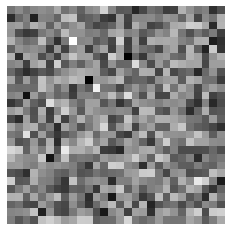

In [167]:
plt.imshow(denorm_image[0].permute(1, 2, 0).cpu(), cmap="gray")
plt.axis(False);

## Discriminator Training

In [168]:
def train_discriminator(discriminator, generator, real_image_batch, loss_fn, opt_dis, opt_gen, latent_size):
    # Setting Devices, Batch Size and Latent
    dis_device = next(discriminator.parameters()).device
    gen_device = next(generator.parameters()).device

    batch_size = real_image_batch.shape[0]
    latent = torch.randn(size=(batch_size, latent_size, 1, 1))

    # Setting Real and Fake Labels
    real_labels = torch.ones(batch_size, 1, device=dis_device)
    fake_labels = torch.zeros(batch_size, 1, device=dis_device)

    # Calculating Loss and Score for Real Images
    real_preds = discriminator(real_image_batch.to(dis_device))

    real_loss = loss_fn(real_preds, real_labels)
    real_score = torch.mean(real_preds).item()

    # Calculating Loss and Score for Fake Images
    fake_images = generator(latent.to(gen_device))

    fake_preds = discriminator(fake_images.to(dis_device))

    fake_loss = loss_fn(fake_preds, fake_labels)
    fake_score = torch.mean(fake_preds).item()

    # Updating Discriminator Parameters
    loss = real_loss + fake_loss

    opt_dis.zero_grad()
    opt_gen.zero_grad()
    loss.backward()
    opt_dis.step()

    return round(loss.item(), 4), round(real_score, 4), round(fake_score, 4)

## Generator Training

In [169]:
def train_generator(discriminator, generator, batch_size, latent_size, loss_fn, opt_dis, opt_gen):
    # Setting Devices, Latent and Labels
    dis_device = next(discriminator.parameters()).device
    gen_device = next(generator.parameters()).device

    latent = torch.randn(size=(batch_size, latent_size))

    labels = torch.ones(batch_size, 1, device=dis_device)

    # Generating Fake image and Calculating Loss
    fake_image = generator(latent.to(gen_device))

    fake_pred = discriminator(fake_image.to(dis_device))

    loss = loss_fn(fake_pred, labels)

    # Updating Generator Parameters
    opt_dis.zero_grad()
    opt_gen.zero_grad()
    loss.backward()  
    opt_gen.step()

    return round(loss.item(), 4), fake_image

## Setting Path for saving the Generated Images


In [170]:
generated_image_path = Path("/content/generated")

if generated_image_path.is_dir():
    rmtree(generated_image_path)

generated_image_path.mkdir(parents=True, exist_ok=True)

In [171]:
# Creating a Function to Save a Grid of Images
def save_gen_images(generator, path, batch_size, latent_size, index=0, images_name="generated_images", nrows=10, print_info=False):
    generator.eval()
    with torch.inference_mode():

        # Creating latent and generating the images
        latent = torch.randn(size=(batch_size, latent_size), device=next(generator.parameters()).device)
        fake_images = generator(latent).reshape(batch_size, 1, 28, 28)
        generated_image_grid_name = f"{images_name}_{index:0=4d}.jpg"
    
    if print_info:
        print(f"\t[INFO] Saving {generated_image_grid_name} to {path}/")

    save_image(denorm(fake_images)[:nrows**2], path / generated_image_grid_name, nrow=nrows)

    if print_info:
        print(f"\t[INFO] {generated_image_grid_name} saved succesfully to {path}/")

In [172]:
save_gen_images(generator, generated_image_path, BATCH_SIZE, LATENT_SIZE)

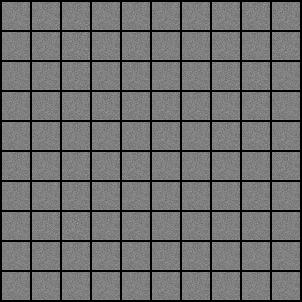

In [173]:
Image(generated_image_path / "generated_images_0000.jpg")

## Creating the Training/Evaluating Loop

In [174]:
def fit(discriminator, generator, epochs, train_dl, latent_size, loss_fn, opt_dis, opt_gen, print_per_epoch=1):
    start_time = timer()

    # Setting Evaluating Lists and Batch Size
    dis_losses, gen_losses = [], []
    real_scores, fake_scores = [], []

    batch_size = train_dl.batch_size

    i = 1
    
    print("Starting Process...\n")

    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch} | Training: ", end="")
        for real_image_batch, _ in tqdm(train_dl):
            
            # Training the 2 models
            dis_loss, real_score, fake_score = train_discriminator(discriminator,
                                                                   generator,
                                                                   real_image_batch,
                                                                   loss_fn,
                                                                   opt_dis,
                                                                   opt_gen,
                                                                   latent_size)
            gen_loss, generated_image = train_generator(discriminator,
                                                        generator,
                                                        batch_size,
                                                        latent_size,
                                                        loss_fn,
                                                        opt_dis,
                                                        opt_gen)
            
        # Updating Evaluating Lists
        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
    
        if epoch % print_per_epoch == 0:

            # Saving the Generated Image Batch
            save_gen_images(generator, generated_image_path, batch_size, latent_size, i)
            i += 1

            # Printing Results
            print(
                f"\tDiscr_Loss: {dis_loss} | "
                f"Gen_Loss: {gen_loss} | "
                f"Real_Score: {real_score} | "
                f"Fake_Score: {fake_score}")
            print('-' * 93, end="\n\n")

    print("Process Completed Succesfully...")

    return dis_losses, gen_losses, real_scores, fake_scores, (timer() - start_time)

## Setting Loss Function and Optimizers

In [175]:
loss_fn = nn.BCELoss()

opt_dis = optim.Adam(discriminator.parameters(), lr=0.0002)
opt_gen = optim.Adam(generator.parameters(), lr=0.0002)

## Training the Model

In [176]:
history = fit(discriminator, generator, 20, train_dl, LATENT_SIZE, loss_fn, opt_dis, opt_gen)

Starting Process...

Epoch: 1 | Training: 

100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


	Discr_Loss: 0.0085 | Gen_Loss: 10.2597 | Real_Score: 0.9929 | Fake_Score: 0.001
---------------------------------------------------------------------------------------------

Epoch: 2 | Training: 

100%|██████████| 469/469 [00:18<00:00, 25.72it/s]


	Discr_Loss: 0.0651 | Gen_Loss: 6.2988 | Real_Score: 0.9836 | Fake_Score: 0.0454
---------------------------------------------------------------------------------------------

Epoch: 3 | Training: 

100%|██████████| 469/469 [00:17<00:00, 27.55it/s]


	Discr_Loss: 0.563 | Gen_Loss: 8.1932 | Real_Score: 0.9591 | Fake_Score: 0.3816
---------------------------------------------------------------------------------------------

Epoch: 4 | Training: 

100%|██████████| 469/469 [00:18<00:00, 25.82it/s]


	Discr_Loss: 0.5619 | Gen_Loss: 6.1274 | Real_Score: 0.8987 | Fake_Score: 0.2044
---------------------------------------------------------------------------------------------

Epoch: 5 | Training: 

100%|██████████| 469/469 [00:26<00:00, 17.86it/s]


	Discr_Loss: 0.368 | Gen_Loss: 3.2148 | Real_Score: 0.8688 | Fake_Score: 0.1195
---------------------------------------------------------------------------------------------

Epoch: 6 | Training: 

100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


	Discr_Loss: 0.0993 | Gen_Loss: 3.6415 | Real_Score: 0.9849 | Fake_Score: 0.0779
---------------------------------------------------------------------------------------------

Epoch: 7 | Training: 

100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


	Discr_Loss: 2.1851 | Gen_Loss: 1.2551 | Real_Score: 0.4889 | Fake_Score: 0.5328
---------------------------------------------------------------------------------------------

Epoch: 8 | Training: 

100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


	Discr_Loss: 0.8725 | Gen_Loss: 1.649 | Real_Score: 0.6372 | Fake_Score: 0.1783
---------------------------------------------------------------------------------------------

Epoch: 9 | Training: 

100%|██████████| 469/469 [00:21<00:00, 22.29it/s]


	Discr_Loss: 0.3866 | Gen_Loss: 3.3375 | Real_Score: 0.8576 | Fake_Score: 0.1526
---------------------------------------------------------------------------------------------

Epoch: 10 | Training: 

100%|██████████| 469/469 [00:17<00:00, 27.06it/s]


	Discr_Loss: 0.2744 | Gen_Loss: 3.1314 | Real_Score: 0.8813 | Fake_Score: 0.112
---------------------------------------------------------------------------------------------

Epoch: 11 | Training: 

100%|██████████| 469/469 [00:17<00:00, 27.35it/s]


	Discr_Loss: 0.3213 | Gen_Loss: 2.2899 | Real_Score: 0.9004 | Fake_Score: 0.1824
---------------------------------------------------------------------------------------------

Epoch: 12 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


	Discr_Loss: 1.8238 | Gen_Loss: 1.4457 | Real_Score: 0.6139 | Fake_Score: 0.5605
---------------------------------------------------------------------------------------------

Epoch: 13 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.42it/s]


	Discr_Loss: 0.846 | Gen_Loss: 2.1161 | Real_Score: 0.6689 | Fake_Score: 0.2579
---------------------------------------------------------------------------------------------

Epoch: 14 | Training: 

100%|██████████| 469/469 [00:17<00:00, 27.44it/s]


	Discr_Loss: 0.4084 | Gen_Loss: 2.0432 | Real_Score: 0.8148 | Fake_Score: 0.1752
---------------------------------------------------------------------------------------------

Epoch: 15 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.86it/s]


	Discr_Loss: 8.9834 | Gen_Loss: 1.8058 | Real_Score: 0.0987 | Fake_Score: 0.7477
---------------------------------------------------------------------------------------------

Epoch: 16 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.39it/s]


	Discr_Loss: 1.799 | Gen_Loss: 2.2498 | Real_Score: 0.6787 | Fake_Score: 0.5806
---------------------------------------------------------------------------------------------

Epoch: 17 | Training: 

100%|██████████| 469/469 [00:17<00:00, 27.28it/s]


	Discr_Loss: 2.2997 | Gen_Loss: 1.5633 | Real_Score: 0.6075 | Fake_Score: 0.6805
---------------------------------------------------------------------------------------------

Epoch: 18 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.15it/s]


	Discr_Loss: 0.7252 | Gen_Loss: 2.0601 | Real_Score: 0.8204 | Fake_Score: 0.2743
---------------------------------------------------------------------------------------------

Epoch: 19 | Training: 

100%|██████████| 469/469 [00:16<00:00, 28.47it/s]


	Discr_Loss: 0.6122 | Gen_Loss: 3.3612 | Real_Score: 0.8476 | Fake_Score: 0.2536
---------------------------------------------------------------------------------------------

Epoch: 20 | Training: 

100%|██████████| 469/469 [00:17<00:00, 26.98it/s]

	Discr_Loss: 0.3246 | Gen_Loss: 2.8687 | Real_Score: 0.8889 | Fake_Score: 0.1034
---------------------------------------------------------------------------------------------

Process Completed Succesfully...


## Plotting Loss Curves

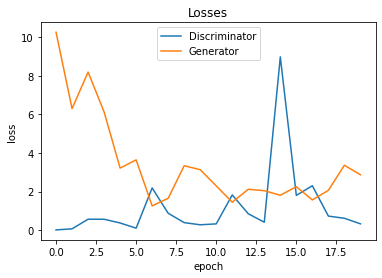

In [178]:
plt.plot(history[0], '-')
plt.plot(history[1], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Plotting Scores

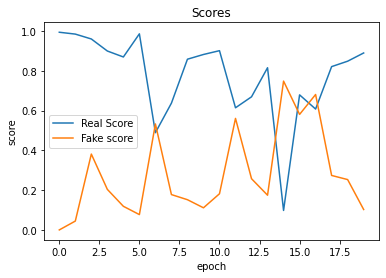

In [179]:
plt.plot(history[2], '-')
plt.plot(history[3], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Converting the Images into a Video

In [181]:
import cv2
import os

vid_fname = "gans_training.avi"
sample_dir = "/content/generated"

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if "generated_images" in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*"MP4V"), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()